In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import json
import time
import ast
import ijson
from itertools import islice

### json 데이터 리스트 확인

In [2]:
# json 파일 위치 지정
dir_path = '/Volumes/Submit_data/210219_100pro/image/'

category = ['H','H_pair','L', 'L_pair', 'M', 'M_pair']
json_files = [f for f in os.listdir(dir_path) if f.endswith('.json')]
json_files

['metadata_H.json',
 'metadata_H_pair.json',
 'metadata_L.json',
 'metadata_L_pair.json',
 'metadata_M.json',
 'metadata_M_pair.json']

### json 파일을 읽어와서 데이터프레임 형식(csv)으로 저장

In [26]:
for char in category:
    df_pair = pd.DataFrame({})
    filename = os.path.join(dir_path,'metadata_%s.json'%char)
    with open(filename, 'r') as f:
        objects = ijson.items(f, 'item')
        columns = list(objects)
        temp = pd.DataFrame(columns)
        temp['individual_factors']=[li[0] for li in temp['individual_factors']]
        json_struct = json.loads(temp.to_json(orient="records"))    
        df_orig = pd.io.json.json_normalize(json_struct)
        df_orig.columns=[c.split('.')[-1] for c in df_orig.columns]
        
        # 전체 json 값 중 분석에 필요한 컬럼값 지정 
        df_orig = df_orig[['individual_temp', 'image_id', 'temp_inside', 'humid_inside','outer_exists', 'camera_temp', 'age', 'bbox', 'gender', 'mask_exists']]
        df_pair = pd.concat([df_pair, df_orig],axis=0)
        df_pair.to_csv('input_%s.csv'%char,index=False)
        
        #  json 파일의 사이즈가 클 경우 200개씩 나눠서 읽어 옴
        objects = islice(objects, 200)
        
        # 각 파일마다 저장된 데이터 개수 확인 
        print(len(df_pair))

358428
3189
27534
5126
74781
16378


In [22]:
# 데이터프레임 내용 확인 
df_pair.head(2)

,camera_type,individual_temp,image_id,temp_inside,humid_inside,outer_exists,camera_temp,age,bbox,gender,mask_exists
0,H,36.1,A1_H_T_20201110_120952,21.3,23.0,True,35.9,middle-age,"[898, 506, 224, 235]",male,True
1,H,36.7,A1_H_T_20201110_122515,21.3,23.0,True,36.3,middle-age,"[696, 469, 231, 245]",male,True


In [30]:
# 분석할 데이터프레임(csv 파일) 리스트
df_list = [df for df in os.listdir('./') if df.endswith('.csv') and not df.endswith(('100.csv','t.csv'))]
df_list

['input_H.csv',
 'input_L.csv',
 'input_H_pair.csv',
 'input_M.csv',
 'input_M_pair.csv',
 'input_L_pair.csv']

### 열화상 이미지 정보 컬럼 추가

In [ ]:
category = ['H_pair', 'L_pair', 'M_pair','H','L', 'M']
for char in category:
    df_name = 'input_%s.csv'%char
    img_path = '/Volumes/Submit_data/210219_100pro/image/%s/dataset'%char
    
    df = pd.read_csv(df_name)
    pixel_val=[]
    for i in range(len(df)):
        img = df.loc[i,'image_id']
        bbox = df.loc[i,'bbox']
        if type(bbox)!=list:
            bbox = ast.literal_eval(bbox)
        file= '%s/%s.jpg'%(img_path,img)
        try:
            image = cv2.imread(file)
            image = image[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[3]]
            pixel_val.append(np.mean(image[:,:,2]))
#             print('->', end=' ')
        except:
            print(file)
            pixel_val.append(0)
    df['pixel_val'] = pixel_val
    df.to_csv(df_name, index=False)

### 전체 데이터 셋 병합 및 중복 제거 

In [79]:
resolution = ['H_pair', 'L_pair', 'M_pair','H','L', 'M']

df = pd.DataFrame({})
for r in resolution:
    temp = pd.read_csv(f'input_{r}.csv')
    df = pd.concat([df, temp])
#     print(len(df))

# 병합된 전체 데이터셋 크기 확인
len(df)

485436

In [82]:
# 전체 데이터셋 중 image_id가 유일한 데이터 개수 확인 
print(f'유일 데이터 개수 : {len(df["image_id"].unique())}')

print(f'중복 데이터 개수 : {len(df)-len(df["image_id"].unique())}')

유일 데이터 개수 : 460743
중복 데이터 개수 : 24693


In [83]:
# image_id 컬럼을 기준으로 중복 데이터 제거
df = df.drop_duplicates(subset=['image_id'])

# 중복을 제거한 데이터셋 개수  확인
len(df)

460743

### 열화상 이미지 정보 결측 제거

In [84]:
dff = df.copy()
del dff['temp_inside']
del dff['humid_inside']

In [88]:
# 결측치를 0으로 채움
dff = dff.fillna(0)

In [89]:
# 결측치 제거 전 데이터셋 개수
len(dff)

460743

In [90]:
# dff = df[df['temp_inside']!=0]
# print(len(dff))

# 결측치 제거 후 데이터셋 개수
dff = dff[dff['pixel_val']!=0]
len(dff)

460562

In [91]:
dff.to_csv('total_input_02.csv', index=False)

In [92]:
# 실측 체온 데이터가 있는 데이터프레임(orig)과 없는 데이터프레임(pred) 분할
pred = dff[dff['individual_temp']==0]
orig = dff[dff['individual_temp']!=0]

In [96]:
# 데이터셋 개수 확인
print(f'전체 데이터셋 개수 : {len(dff)}개')
print(f'실측체온이 없는 데이터 개수 : {len(pred)}개')
print(f'실측체온이 있는 데이터 개수(pair) : {len(orig)}개')

전체 데이터셋 개수 : 460562개
실측체온이 없는 데이터 개수 : 435034개
실측체온이 있는 데이터 개수(pair) : 25528개


### pair 데이터를 학습하여 실측체온 예측 모델 학습
#### - input : camera_temp, outer_exists, age, gender, mask_exists
#### - output : individual_temp

In [98]:
orig.head(2)

,individual_temp,image_id,outer_exists,camera_temp,age,bbox,gender,mask_exists,pixel_val
0,36.1,A1_H_T_20201110_120952,True,35.9,middle-age,"[898, 506, 224, 235]",male,True,220.124943
1,36.7,A1_H_T_20201110_122515,True,36.3,middle-age,"[696, 469, 231, 245]",male,True,228.264490


In [100]:
test = orig.copy()

# 사용하지 않는 컬럼 제거 
del test['bbox']
del test['image_id']
del test['pixel_val']

# 범주형 데이터는 분리하여 처리 
category = ["outer_exists","age","gender","mask_exists"]
data = test.drop(category, axis=1)
data.head(5)

,individual_temp,camera_temp
0,36.1,35.9
1,36.7,36.3
2,37.3,36.9
3,36.8,36.1
4,36.6,36.9


#### 범주형 데이터 one-hot 인코딩

In [102]:
from sklearn.preprocessing import OneHotEncoder

# 범주형 데이터 onehot encoding
data_cat = test[category]
onehot_encoder = OneHotEncoder()
data_cat_onehot = onehot_encoder.fit_transform(data_cat)
# print(onehot_encoder.categories_)

# 원핫인코딩한 범주형 데이터의 새로운 컬럼 이름 지정 
new_col = []
for i in range(len(category)):
    for j in range(len(onehot_encoder.categories_[i])):
        cat = f'{category[i]}_{onehot_encoder.categories_[i][j]}'
        new_col.append(cat)
        
# 컬럼명 확인
new_col

['outer_exists_False',
 'outer_exists_True',
 'age_child',
 'age_middle-age',
 'age_old-age',
 'age_youth',
 'gender_female',
 'gender_male',
 'mask_exists_False',
 'mask_exists_True']

In [103]:
# 컬럼 병합
data2 = np.c_[data_cat_onehot.toarray(),data]
dt = pd.DataFrame(data2, columns=new_col+list(data.columns))
dt.head(3)

,outer_exists_False,outer_exists_True,age_child,age_middle-age,age_old-age,age_youth,gender_female,gender_male,mask_exists_False,mask_exists_True,individual_temp,camera_temp
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,36.1,35.9
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,36.7,36.3
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,37.3,36.9


In [104]:
from sklearn.model_selection import train_test_split

# train/test 셋 분할 (전체 데이터셋의 10%를 test셋으로 분할)
train_set, test_set = train_test_split(dt, test_size=0.1, random_state=47)

# 학습을 위한 input, output 셋 분할 
train_data = train_set.drop("individual_temp", axis=1)
train_data_label = train_set["individual_temp"].copy()
test_data = test_set.drop("individual_temp", axis=1)
test_data_label = test_set["individual_temp"].copy()


#### 랜덤 포레스트 회귀 모델 학습

In [105]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(train_data, train_data_label)

# 학습 결과 확인 (MSE)
from sklearn.metrics import mean_squared_error
some_predicted = model.predict(test_data)
mse = np.sqrt(mean_squared_error(some_predicted, test_data_label))
print('MSE :', mse)


MSE : 1.149857301527607


/Users/xiilab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [106]:
# 학습 결과 확인 (MAPE)
mape = 0

for i in range(len(test_data_label)):
    if(test_data_label.iloc[i]==0):
        pass
    mape += np.abs(test_data_label.iloc[i]-some_predicted[i])/test_data_label.iloc[i]
mape *= (100/len(test_data_label))
print(f'MAPE : {mape}')
print('accuracy : %s%%'%(100-mape))

MAPE : 2.9640672153437393
accuracy : 97.03593278465627%


In [107]:
# 모델 저장
import joblib

filename = 'pred_model.sav'
joblib.dump(model, filename)

['pred_model.sav']

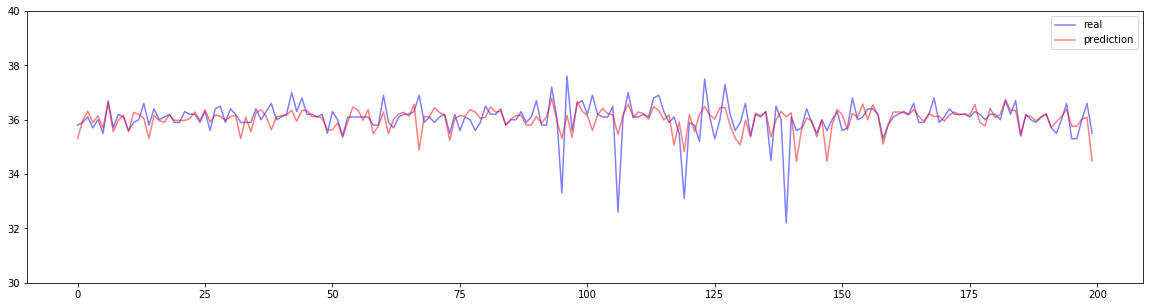

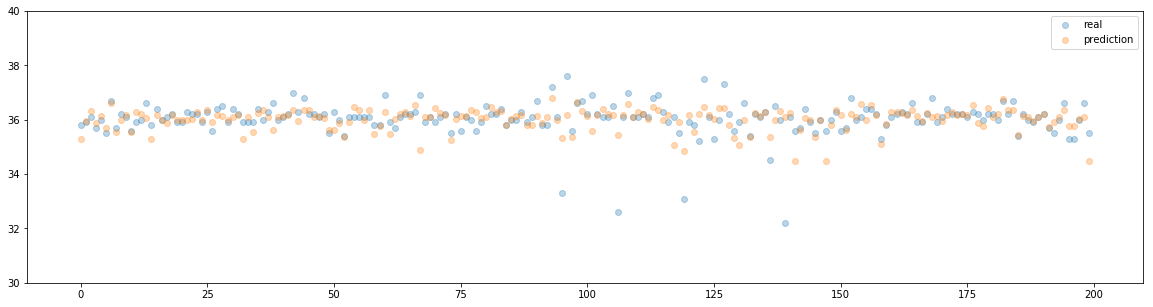

In [108]:
# 결과 시각화
n = 200
plt.plot(list(test_data_label)[:n],'b', alpha=0.5)
plt.plot(list(some_predicted)[:n],'r', alpha=0.5)
plt.rcParams["figure.figsize"] = (20,5)
plt.ylim(30,40)
plt.legend(['real','prediction'])
plt.show()

plt.scatter(range(n),list(test_data_label)[:n],alpha=0.3)
plt.scatter(range(n),list(some_predicted)[:n], alpha=0.3)
plt.rcParams["figure.figsize"] = (20,5)
plt.ylim(30,40)
plt.legend(['real','prediction'])
plt.show()

### 예측 모델을 통한 실측 체온 결측치 업데이트
#### - model : dataset_model.sav
#### - input : 카메라 측정 체온, 나이, 성별, 외투 여부, 마스크 여부
#### - output : 체온계 측정 체온

In [112]:
pred = dff[dff['individual_temp']==0]
test = pred.copy()

# 사용하지 않는 컬럼 제거 
del test['bbox']
del test['image_id']
del test['pixel_val']

# 범주형 데이터는 분리하여 처리 
category = ["outer_exists","age","gender","mask_exists"]
data = test.drop(category, axis=1)
data.head(5)

,individual_temp,camera_temp
0,0.0,36.6
1,0.0,36.4
2,0.0,36.4
3,0.0,36.5
4,0.0,36.6


In [113]:
from sklearn.preprocessing import OneHotEncoder

# 범주형 데이터 onehot encoding
data_cat = test[category]
onehot_encoder = OneHotEncoder()
data_cat_onehot = onehot_encoder.fit_transform(data_cat)
# print(onehot_encoder.categories_)

# 원핫인코딩한 범주형 데이터의 새로운 컬럼 이름 지정 
new_col = []
for i in range(len(category)):
    for j in range(len(onehot_encoder.categories_[i])):
        cat = f'{category[i]}_{onehot_encoder.categories_[i][j]}'
        new_col.append(cat)
        
# 컬럼명 확인
new_col

['outer_exists_False',
 'outer_exists_True',
 'age_child',
 'age_middle-age',
 'age_old-age',
 'age_youth',
 'gender_female',
 'gender_male',
 'mask_exists_False',
 'mask_exists_True']

In [114]:
# 컬럼 병합
data2 = np.c_[data_cat_onehot.toarray(),data]
dt = pd.DataFrame(data2, columns=new_col+list(data.columns))
dt.head(3)

,outer_exists_False,outer_exists_True,age_child,age_middle-age,age_old-age,age_youth,gender_female,gender_male,mask_exists_False,mask_exists_True,individual_temp,camera_temp
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,36.6
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,36.4
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,36.4


In [115]:
# 예측 input 데이터프레임 
input_data = dt.drop("individual_temp", axis=1)

In [118]:
# 예측 모델 로드
file_name = 'pred_model.sav'
loaded_model = joblib.load(file_name)

# 예측
result = loaded_model.predict(input_data)

# 예측 결과 컬럼 저장 
pred['individual_temp'] = [round(res,2) for res in list(result)]

/Users/xiilab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [119]:
pred.head(3)

,individual_temp,image_id,outer_exists,camera_temp,age,bbox,gender,mask_exists,pixel_val
0,36.75,A1_H_T_20201012_075143,True,36.6,middle-age,"[1056, 524, 179, 211]",male,True,219.823027
1,36.44,A1_H_T_20201012_075245,True,36.4,middle-age,"[1, 260, 109, 205]",male,True,124.332826
2,36.34,A1_H_T_20201012_080044,False,36.4,middle-age,"[14, 227, 126, 126]",male,True,200.188776


In [120]:
test.head(3)

,individual_temp,outer_exists,camera_temp,age,gender,mask_exists
0,0.0,True,36.6,middle-age,male,True
1,0.0,True,36.4,middle-age,male,True
2,0.0,False,36.4,middle-age,male,True


In [123]:
# pair 데이터셋과 예측 데이터셋 병합 
df = pd.concat([orig, pred])

In [124]:
df.to_csv('total_input_finalized_02.csv', index=False)

In [125]:
len(df)

460562

### 결측없는 전체 데이터셋으로 학습 (약 46만개) : total_input_finalized_02.csv
#### - input : 카메라 측정 체온, 나이, 성별, 외투 여부, 마스크 여부, 열화상 이미지 
#### - output : 체온계 측정 체온

In [133]:
# 학습 데이터셋 확인
df = pd.read_csv('total_input_finalized_02.csv')

print(f'학습 데이터 개수 : {len(df)}')

학습 데이터 개수 : 460562


In [134]:
df.head(3)

,individual_temp,image_id,outer_exists,camera_temp,age,bbox,gender,mask_exists,pixel_val
0,36.1,A1_H_T_20201110_120952,True,35.9,middle-age,"[898, 506, 224, 235]",male,True,220.124943
1,36.7,A1_H_T_20201110_122515,True,36.3,middle-age,"[696, 469, 231, 245]",male,True,228.264490
2,37.3,A1_H_T_20201110_124310,False,36.9,youth,"[488, 549, 175, 141]",female,True,223.723253


In [139]:
# 사용하지 않는 컬럼 제거 
del df['bbox']
del df['image_id']

# 범주형 데이터는 분리하여 처리 
category = ["outer_exists","age","gender","mask_exists"]
data = df.drop(category, axis=1)
data.head(5)
# 범주형 데이터 onehot encoding
data_cat = df[category]
onehot_encoder = OneHotEncoder()
data_cat_onehot = onehot_encoder.fit_transform(data_cat)
# print(onehot_encoder.categories_)

# 원핫인코딩한 범주형 데이터의 새로운 컬럼 이름 지정 
new_col = []
for i in range(len(category)):
    for j in range(len(onehot_encoder.categories_[i])):
        cat = f'{category[i]}_{onehot_encoder.categories_[i][j]}'
        new_col.append(cat)
        
# 컬럼 병합        
data2 = np.c_[data_cat_onehot.toarray(),data]
dt = pd.DataFrame(data2, columns=new_col+list(data.columns))
dt.head(3)

# train/test 셋 분할 (전체 데이터셋의 10%를 test셋으로 분할)
train_set, test_set = train_test_split(dt, test_size=0.1, random_state=47)

# 학습을 위한 input, output 셋 분할 
train_data = train_set.drop("individual_temp", axis=1)
train_data_label = train_set["individual_temp"].copy()
test_data = test_set.drop("individual_temp", axis=1)
test_data_label = test_set["individual_temp"].copy()

# random forest 회귀 모델 학습
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(train_data, train_data_label)

# 학습 결과 확인 (MSE)
from sklearn.metrics import mean_squared_error
predicted = model.predict(test_data)
mse = np.sqrt(mean_squared_error(predicted, test_data_label))
print('MSE :', mse)

# 학습 결과 확인 (MAPE)
mape = 0

for i in range(len(test_data_label)):
    if(test_data_label.iloc[i]==0):
        pass
    mape += np.abs(test_data_label.iloc[i]-predicted[i])/test_data_label.iloc[i]
mape *= (100/len(test_data_label))
print(f'MAPE : {mape}')
print('accuracy : %s%%'%(100-mape))

# 모델 저장
import joblib

filename = 'final_model.sav'
joblib.dump(model, filename)

/Users/xiilab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MSE : 0.2835063845716602
MAPE : 0.12722707743422976
accuracy : 99.87277292256577%


['final_model.sav']

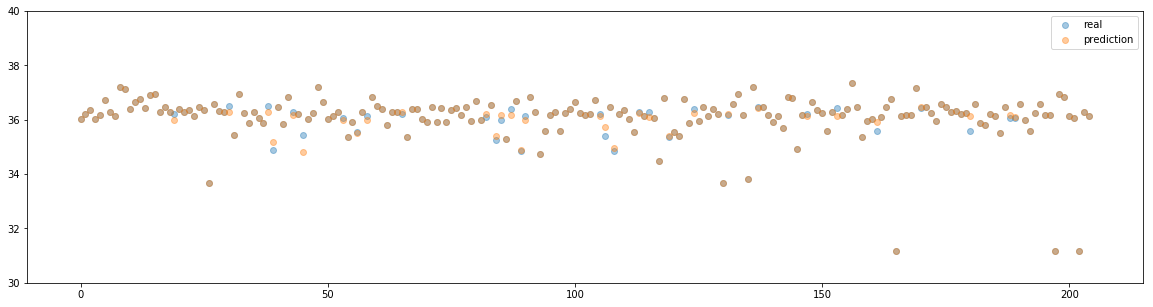

In [174]:
a = 1215
b = 1420
plt.scatter(range(b-a),list(test_data_label)[a:b],alpha=0.4)
plt.scatter(range(b-a),list(some_predicted)[a:b], alpha=0.4)
plt.rcParams["figure.figsize"] = (20,5)
plt.ylim(30,40)
plt.legend(['real','prediction'])
plt.show()

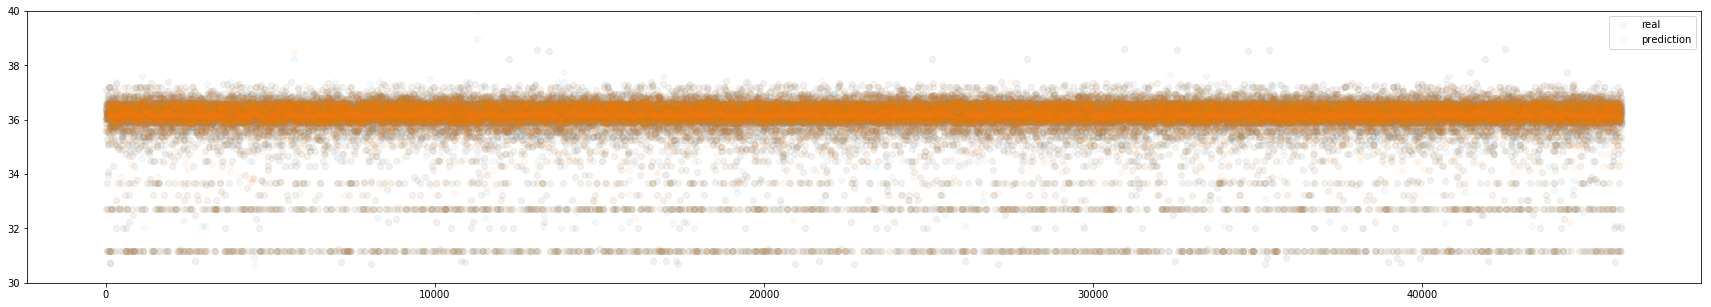

In [155]:
plt.scatter(range(len(list(test_data_label))),list(test_data_label),alpha=0.05)
plt.scatter(range(len(list(some_predicted))),list(some_predicted), alpha=0.05)
plt.rcParams["figure.figsize"] = (20,5)
plt.ylim(30,40)
plt.legend(['real','prediction'])
plt.show()

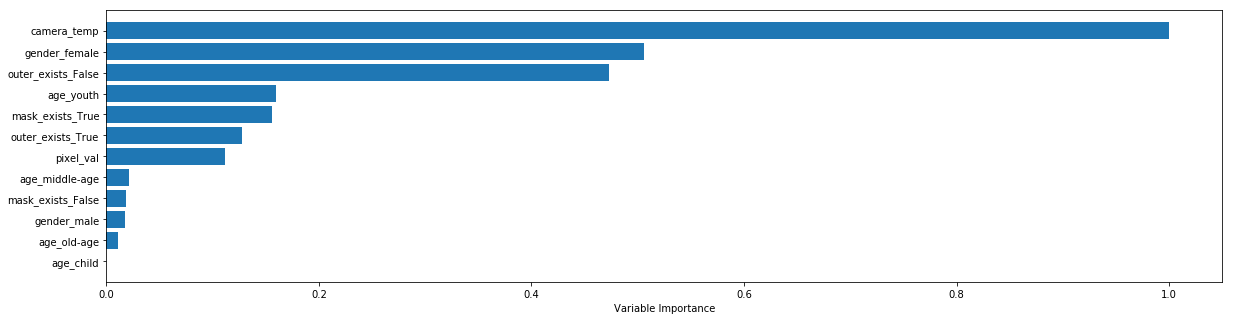

In [161]:
featureImportance = model.feature_importances_
featureImportance = featureImportance/featureImportance.max()
sorted_idx = list(np.argsort(featureImportance))
barPos = np.arange(12)+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, test_data.columns[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()